# DM Etude thermique

- author : Sylvie Dagoret-Campagne
- afflilation : LAL/IJCLab, CNRS
- creation date : Mars 14 2021
- update : Mars 16 2021
 

## Table des constantes de astropy
https://docs.astropy.org/en/stable/constants/

In [1]:
from astropy import constants as const

In [2]:
from astropy.constants import m_e,c,eps0,e,R_sun

In [3]:
from astropy import units as u

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import numpy as np
import re
import time
from datetime import datetime,date,timedelta
import dateutil.parser
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import Angle
from astropy import units as u

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx

In [7]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(8,4)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 

In [8]:
from scipy import signal

In [9]:
from dateutil.relativedelta import relativedelta

In [10]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

# Preambule

## Question 1.1 : Modélisation de la pièce

In [11]:
a = 8.0 # Longueur en m
b = 5.  # largeur en m
h = 2.5 # hauteur en m

In [12]:
Cv_air = 1.25e3 # J/m3/K : capacité thermique volumique de l'air

In [13]:
P = 2000. # W : puissance du radiateur 

### Question 1.1.a : capacité thermique de la piece 

In [14]:
C = Cv_air*a*b*h # capacité thermique de la pièce
C  # J/K

125000.0

### Question 1.1.b : Bilan thermique 

$$
P = C \frac{dT}{dt}
$$

d'où

$$
T = T_0 + \frac{P}{C}(t-t_0)
$$

### Question 1.1.c : Durée

In [15]:
T_i = 10 # degres
T_f = 20 # degres
Delta_T = T_f  - T_i

In [16]:
t= Delta_T*C/P

In [17]:
t # temps en secondes pour passer de 10 à 20°

625.0

$$
\Delta t = 10 min 25 secondes
$$

## Influence des murs

### Paramètres du mur

In [18]:
L=0.15 # m : epaisseur des murs

In [19]:
c_mur= 1e3 # J kg-1 K-1 : capacité thermique massique du mur

In [20]:
rho_mur= 2.2e3 # kg/m3 : densité du mur

In [21]:
cond_th_mur=1.5 # W/m/K : conductivité thermique du mur 

### Question 1.2.a : Surface des murs

In [22]:
S_p=2*(h)*(a+b)
S_p # m2 : surface des murs

65.0

### Question 1.2.b : Volume des murs et capacité thermique des murs

$$
V_b = S_p L
$$

et

$$
C_{mur} = \rho S_p L c_{mur}
$$

In [23]:
Vb=S_p*L
Vb  #  m3 : volume de béton des murs

9.75

In [24]:
M_mur=Vb*rho_mur # kg : masse totale du mur 

In [25]:
C_mur = c_mur*M_mur  # Capacité thermique des mur
C_mur  #  J/K

21450000.0

In [26]:
C # capacité calorifique de la pièce

125000.0

In [27]:
C_mur/C

171.6

La capacité calorifique du mur est 172 fois plus grande que celle de l'air de la pièce. Les murs sont capable
de stocker plus facilement de la chaleur que l'air.

Comme $\frac{\Delta T}{dt}= \frac{P}{C}$, il est plus facile (rapide) d'augmenter la température de l'air que celle du mur.

# Première partie : équation de la chaleur

## Généralités

### Question 1.3.a : Loi de Fourier

$$
\frac{dQ}{dt} = - S \lambda  \nabla  T
$$

- $\lambda$ : conductivité thermique en W/m/K

### Question 1.3.b : Equation différentielle

- Différence entre flux entrant et sortant

$$
Q(x) = - \lambda \frac{dT}{dx}(x)S \Delta t \\
Q(x+dx) = - \lambda \frac{dT}{dx}(x+dx)S \Delta t \\
\Delta Q = - \lambda S \Delta t \frac{d^2 T}{dx^2}(x)
$$

- Stockage d'énergie dans l'élément de mur d'épaisseur $dx$ et de masse :

$$
dM = \rho S dx \\
$$

- chaleur emmagasinée par le mur
$$
dQ_{abs} = - c_{mur} \rho dx dT
$$

$$
\Delta Q = dQ_{abs}
$$

L'équation différentielle est:
$$
\lambda \frac{d^2 T}{dx^2} - \rho c_{mur} \frac{dT}{dt} =0
$$

## Etude du régime stationnaire : 1.4

In [28]:
Tint=20
Text=10
DT=Tint-Text

### Question 1.4.a : définition du régime stationnaire

$$
\frac{dT}{dt} = 0
$$

### Question 1.4.b : Résoudre l'équation en régime stationnaire:

$$
T(x) = T_{int} + \frac{x}{L}(T_{ext}-T_{int})
$$

In [29]:
def T(x):
    """
    """ 
    y=np.where(x<0,0,x)
    z=np.where(x>L,L,y)
    
    
    Tx= Tint - x/L*DT
    return Tx

Text(0.5, 1.0, 'Température dans le mur en fonction de $x$')

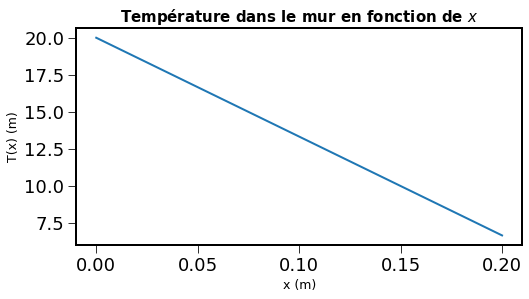

In [30]:
x=np.linspace(0,0.20,100)
plt.plot(x,T(x))
plt.xlabel("x (m)")
plt.ylabel("T(x) (m)")
plt.title("Température dans le mur en fonction de $x$")

### Question 1.4.c : Température moyenne

$$
T_{moy} = \frac{1}{L} \int_{x=0}^{x=L} T(x) dx
$$

$$
T_{moy} = \frac{T_{int}+T_{ext}}{2}
$$

$$
x_p = \frac{L}{2}
$$

### Question 1.4.d : Flux qui traverse le mur

$$
j = - \lambda \nabla T = - \frac{\lambda}{L}(T_{ext}-T_{int})
$$

- Le flux est indépendant de $x$

### Question 1.4.e : Puissance du radiateur pour maintenir une température de 20 degrés dans la pièce

$$
P = \frac{dQ}{dt} = j \cdot S = \frac{\lambda S}{L}(T_{ext}-T_{int})
$$

In [31]:
P=S_p*cond_th_mur/L*DT
P  # en W

6500.0

## Résistance thermique

### Question 1.5.a

- Loi d'Ohm
$$
j = \sigma E
$$

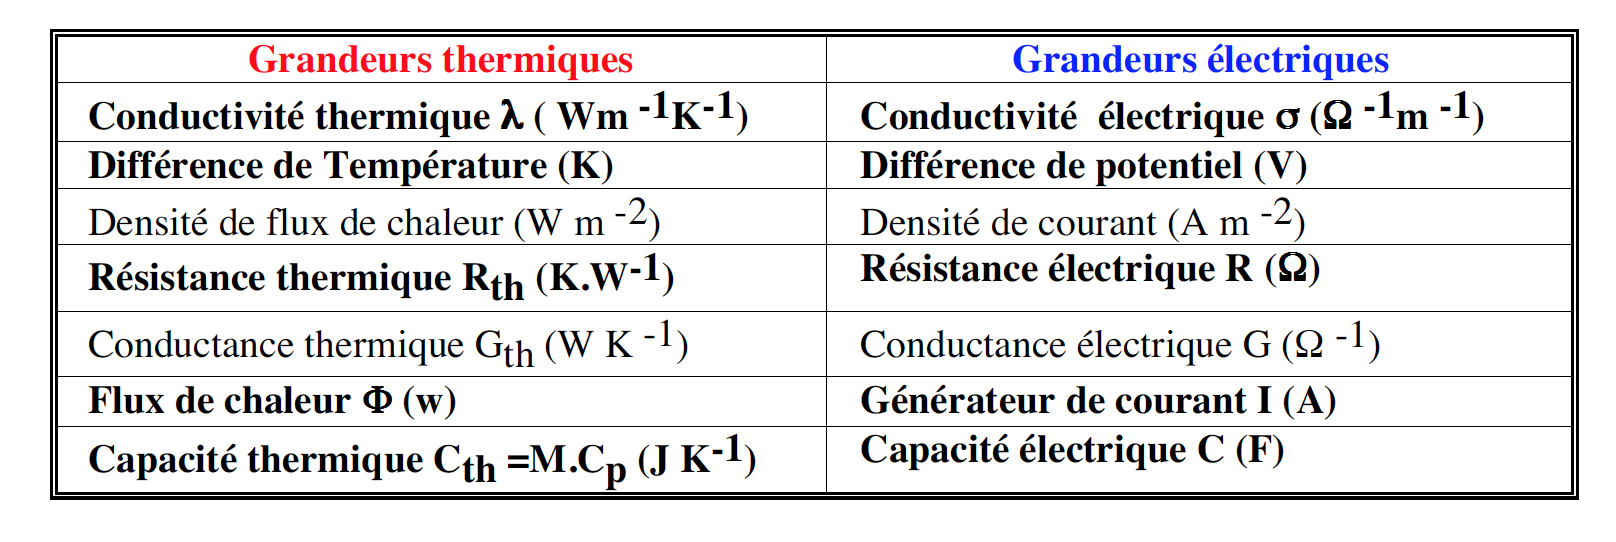

In [32]:
from IPython.display import Image# Load image from local storage
Image(filename = "tableauequivalence.png", width = 600, height = 300)

### Question 1.5.b : Résistance thermique du mur

$$
R_{th} = \frac{1}{\lambda} \frac{L}{S}
$$

In [33]:
Rth_mur= 1/cond_th_mur*L/S_p
Rth_mur # résistance thermique du mur en K/W

0.0015384615384615382

# Deuxième partie : modélisation électrique

## Circuit électrique : 1.6

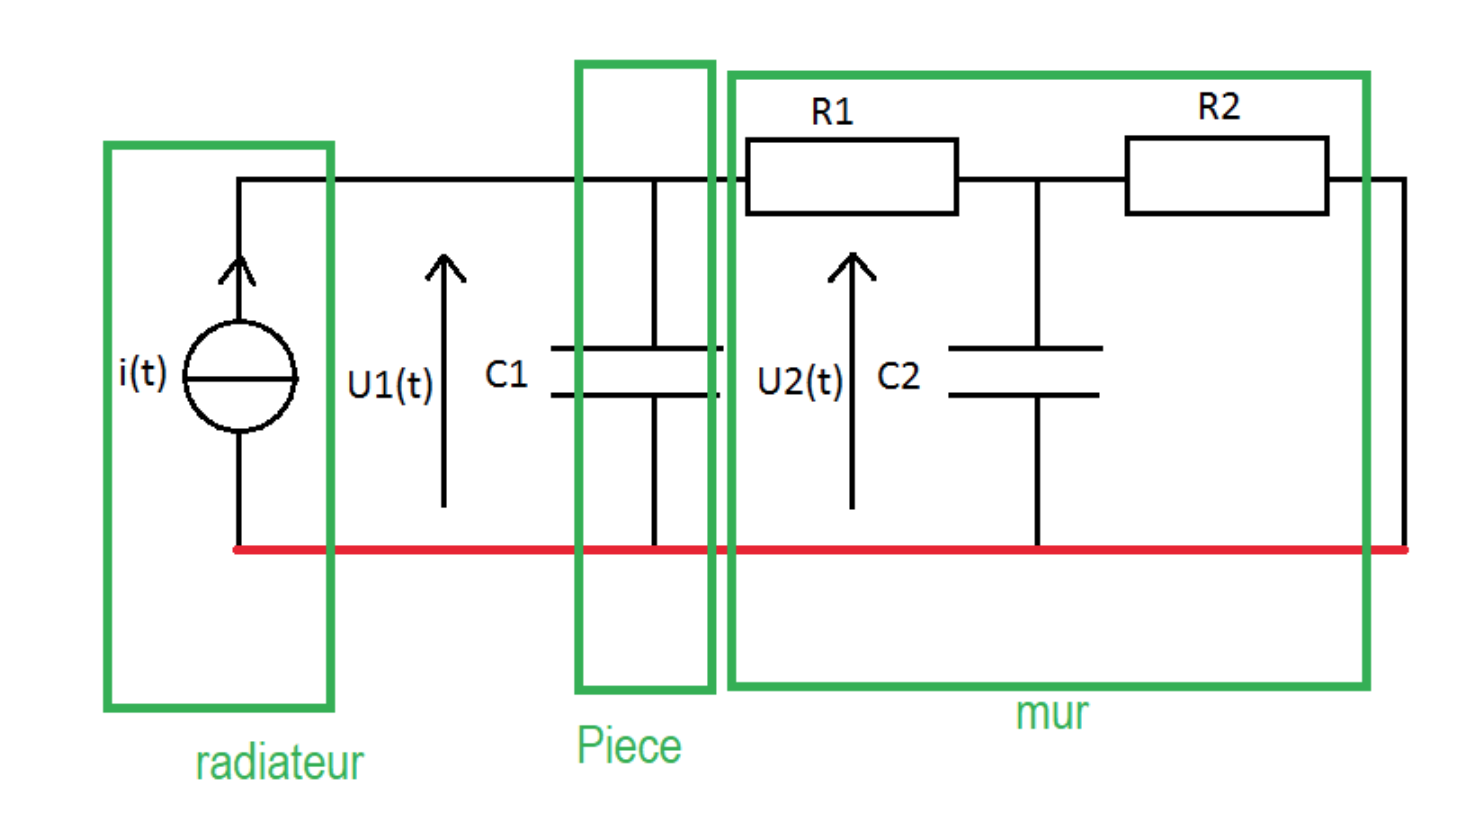

In [34]:
from IPython.display import Image# Load image from local storage
Image(filename = "shemaelectrique.png", width = 600, height = 300)

- $U1(t)$ c'est $T_{int}$
- $U2(t)$ c'est $T_{moy}$
- $I(t)$ c'est $P$ la puissance thermique du radiateur
- $C1$ c'est la capacité calorifique de la pièce
- $C2$ c'est la capacité calorifique du mur
- $R1,R2 = \frac{1}{\lambda}\frac{L}{2S}$ ce sont les résistances thermiques de la moitié intérieure et moitié exterieure du mur dont la conductivité thermique est $\lambda$ en $W/m/K$

### Question 1.6.b circuit en régime permanent continu

- équation électrique
$$
U = (R_1+R_2) i
$$

- equation thermique
$$
P_{th} = \frac{T_{int}-T_{ext}}{R_{th 1}+ R_{th2}}
$$

In [35]:
Rth1=Rth_mur/2
Rth2=Rth_mur/2

In [36]:
Rth1 # K/W

0.0007692307692307691

## Etablissement de l'expression de l'impédance : 1.7

###  Question 1.7.a

$$
Z_2 = \frac{R_2}{1+j R_2 C_2 \omega}
$$

### Question 1.7.b 

$$
Z_1 = R_1 + Z_2
$$

### Question 1.7.c

$$
Z_1 = R_1 + \frac{R_2}{1+j R_2 C_2 \omega} = \frac{(R_1+R_2)+j R_1 R_2 C_2 \omega}{1+j R_2 C_2 \omega} \\
Y_1 = \frac{1+j R_2 C_2 \omega}{(R_1+R_2)+j R_1 R_2 C_2 \omega}
$$

$$
Y_{tot} = j C_1 \omega + Y_1 = j C_1 \omega + \frac{1+j R_2 C_2 \omega}{(R_1+R_2)+j R_1 R_2 C_2 \omega}
$$

### Question 1.7.d

$$
\frac{U_1}{I_0} = \frac{1 + j \frac{R_1 R_2}{R_1+R_2}C_2 \omega}{1 + j\left((R_1+R_2)C_1 +R_2C_2\right)\omega -R_1R_2C_1C_2 \omega^2}(R_1+R_2)
$$

## Exploitation

### Question 1.8.a

$$
\lim_{\omega \rightarrow 0} \frac{U_1}{I_0} = (R_1+R_2) 
$$

### Question 1.8.b

$$
\lim_{\omega \rightarrow \infty} \frac{U_1}{I_0} = \frac{1}{jC_1 \omega} 
$$

### Question 1.8.c

- **C'est un filtre passe bas du 1er ordre**

### Question 1.8.d

$$
\frac{U_1}{I_0} = R \frac{1 + j \frac{\alpha}{4} RC \omega}{1 + j RC (1+ \frac{\alpha}{2})\omega - \frac{\alpha}{4}(RC)^2 \omega^2}
$$

- **Avec ce genre d'expression il faut se ramener très vite à des paramètres qu'on connait par coeur en terme de $\omega_0$, $\xi$, $Q$ pour pouvoir faire des calculs très rapidement sans se trimbaler des $RC$ et $\alpha$**

On pose:

- la pulsation propre:

$$
\omega_0 = \frac{2}{\sqrt{\alpha} RC}
$$

- le zéro:
$$
\omega_1 = \frac{4}{\alpha RC} 
$$

- le coefficient d'amortissement
$$
\xi = \frac{1}{2Q}=  \frac{1 + \frac{\alpha}{2}}{\sqrt{\alpha}}
$$

- $Q= \frac{1}{2\xi}$ est le facteur de qualité

$$
\frac{U_1}{I_0}(\omega) = R \frac{1+j \frac{\omega}{\omega_1}}{1 + j 2 \xi \frac{\omega}{\omega_0} + \left( \frac{\omega}{\omega_0}\right)^2}
$$

Ce qui peut s'écrire en Tranformée de Laplace avec $p = j \omega$:
    
$$
\frac{U_1}{I_0}(p) = R \frac{1+j \frac{p}{\omega_1}}{1 + 2 \xi \frac{p}{\omega_0} + \left( \frac{p}{\omega_0}\right)^2}
$$    

- Il y a un zero a numérateur pour $p=\omega_1$
- Il y a deux poles au dénominateur de $p$, solution de l'équation du second ordre:

$$
p^2 + 2 \xi \omega_0 p + \omega_0^2 = 0
$$

avec le discriminant (réduit)
$$
\Delta = \omega_0^2(\xi^2-1)
$$
et les racines complexes ou réelles $p_1,p_2$ des pôles  sont:

$$
p_1 = \omega_0(- \xi + \sqrt{\xi^2-1})
$$
et

$$
p_2 = - \omega_0( \xi + \sqrt{\xi^2-1})
$$

- Notons que : 
$$
\frac{\omega_1}{\omega_0} = \frac{2}{\sqrt{\alpha}}
$$
et donc pour $\alpha$ grand, la pulsation du zéro $\omega_1 \ll \omega_0$

- Notons que $\xi \gg 1$ pour $\alpha$ grand, $\omega_1 \ll \omega_0$, le régime est donc très atténué et les racine du dénominateur sont réelles.

Donc le dénominateur de de la fonction de transfert se met sous la forme d'une somme de deux termes d'ordre 1 correspondant à deux régimes exponentiellement atténués:
    
$$
\frac{1}{den} = \frac{A}{p-p_1} + \frac{B}{p-p_2} = \frac{A}{p+\omega_0(\xi -\sqrt{\xi^2-1})} + 
                                                                        \frac{B}{p+\omega_0(\xi +\sqrt{\xi^2-1})}
$$

On définit deux pulsations supplémentaires:

- un pôle avec une pulsation très faible $\omega_3$:
$$
\omega_3 = \omega_0(\xi - \sqrt{\xi^2-1})
$$

- un pôle avec une pulsation élevée $\omega_4$:
$$
\omega_4 = \omega_0(\xi + \sqrt{\xi^2-1})
$$



### Application numérique

In [37]:
alpha = 200
RC= Rth_mur * C_mur
RC # secondes

32999.99999999999

#### Calcul du coefficient d'amortissement

In [38]:
xi=(1+alpha/2)/np.sqrt(alpha)
xi # coefficient d'amortissement > 1 donc régime atténué

7.14177848998413

#### calcul des pulsations $\omega_0,\omega_1,\omega_2, \omega_3$

In [39]:
omega_0=2/np.sqrt(alpha)/RC
omega_0 # rad/s

4.285495643554834e-06

In [40]:
omega_1=2/np.sqrt(alpha)*omega_0
omega_1 # rad/s

6.060606060606061e-07

In [41]:
omega_2=omega_0*(xi - np.sqrt(xi**2-1))
omega_2 # rad/s

3.015151893920457e-07

In [42]:
omega_3=omega_0*(xi + np.sqrt(xi**2-1))
omega_3 # rad/s

6.0910606022729176e-05

#### hiérarchie des $\omega$:

- $\omega_2 < \omega_1 < \omega_0 < \omega_3$   ($\omega_0$ ne joue pas de rôle dans la fonction de transfert)



- On commence par une réponse réelle à $\omega = 0$ en statique,
- Puis quand $\omega$ augmente le pôle $\omega_2$ provoque une chute du gain à - 20dB/decade
- Puis à $\omega= \omega_1$ le zéro compense le pôle et donc la courbe de gain devient plate en fréquence,
- Puis à partir de $\omega=\omega_2$, le second pôle du dénominateur domine avec une chute du gain à - 20dB/decade jusqu'à la fréquence infinie 

### Diagrame de Bode calculé par moi (faux) 

In [43]:
def H(x):
    """
    Fonction de transfert (complexe)
    """
    y = (1+1j/4*alpha*x)/(1 + 1j*RC*x*(1+alpha/2)-alpha/4*RC**2*x**2)
    return y

In [44]:
def Mod(x):
    """
    Module de la fonction de transfert
    """
    return np.abs(H(x))

In [45]:
def Arg(x):
    """
    Argument de la fonction de transfert
    """
    
    realpart = np.real(H(x))
    imagpart = np.imag(H(x))
    
    #angle = np.where(realpart > 0, np.angle(H(x)),  np.angle(H(x)) )
    
    angle = np.angle(H(x))
    
    return angle

In [46]:
# Valeur des Omega en rad/s
X = np.logspace(-8,-2,1000,base=10)

In [47]:
# Module du Gain
G = Mod(X)

In [48]:
# Phase du Gain
Phi= Arg(X)*180./np.pi

In [49]:
# je n'affiche pas car je n'obtiens pas la meme courbe que dans le sujet
if 0:
    # Gain
    plt.figure(figsize=(10,5))
    #plt.loglog(X,G,"b-")
    plt.plot(X,20*np.log10(G),"b-")
    plt.grid()
    plt.xlabel("$\omega$ (rad/s)")
    plt.ylabel("G (dB)")
    plt.title("Gain")
    plt.xscale("log")
    plt.show()

    # Phase
    plt.figure(figsize=(10,5))
    plt.semilogx(X,Phi,"b-")
    plt.grid()
    plt.xlabel("$\omega$ (rad/s)")
    plt.ylabel("$\\Phi$")
    plt.title("Phase")
    plt.show()

### Diagramme de Bode calculé par scipy.signal (juste)

In [50]:
# numérateur de la fonction de la transformée de Laplace (bp +c) [b,c]
num = [ 1./omega_1 , 1. ]
num

[1650000.0, 1.0]

In [51]:
# dénominateur de la fonction de la transformée de Laplace (ap2 +bp +c) [a,b,c]
den = [1./omega_0**2, 2*xi/omega_0,  1.]
den

[54449999999.999985, 3332999.9999999995, 1.0]

In [52]:
# appel à la librairie signal de scipy
s1 = signal.lti(num,den)
w, mag, phase = signal.bode(s1,w=X)

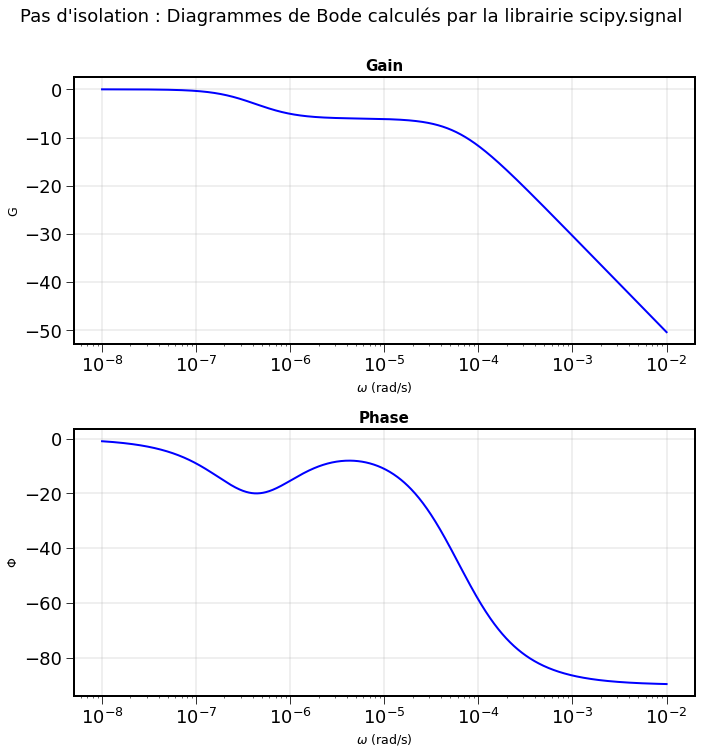

In [53]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.semilogx(w, mag,"b")    # Bode magnitude plot
plt.grid()
plt.xlabel("$\omega$ (rad/s)")
plt.ylabel("G")
plt.title("Gain")


plt.subplot(2,1,2)
plt.semilogx(w, phase,"b")  # Bode phase plot
plt.grid()
plt.xlabel("$\omega$ (rad/s)")
plt.ylabel("$\\Phi$")
plt.title("Phase")

plt.tight_layout()
plt.suptitle("Pas d'isolation : Diagrammes de Bode calculés par la librairie scipy.signal",y=1.05)
plt.show()

- On voit d'abord la réponse plate en fréquence à fréquence nulle
- Puis apparait le pole à $\omega_2$,
- Puis apparait le zéro à $\omega_1$ qui applatit la courbe de gain et provoque la remontée en phase
- Puis finalement à $\omega_2$, le second pôle prend le dessus avec une chute du gain à - 20 dB par décade

**Notons qu'il y a une petite différence dans l'échelle des $\omega$ entre mon calcul et celui de la feuille.
Mais le comportement est le même puisqu'on a la même fonction de transfert**

# Troisieme partie : Isolation

## Importance de l'isolation : partie 1.10

In [54]:
e=0.05 # m épaisseur de l'isolant
cond_th_is=0.05  # W:m/k conductivité thermique de l'isolant

### Question 1.10.a Résistance thermique de l'isolant

In [55]:
Rth_is=1/cond_th_is*e/S_p
Rth_is # K/W : résistance thermique de l'isolant

0.015384615384615385

In [56]:
Rth_mur # K/W : resitance thermique du mur

0.0015384615384615382

- on voit bien que l'isolant est 10 fois plus résistant à la chaleur que le mur

In [57]:
beta=10

### Question 1.10.b : modification du shéma électrique:

- on rajoute $T_{th is}$ soit à $R_1$, soit à $R_2$.

### Question 1.10.c : Puissance minimale necessaire pour maintenir la pièce à 20°

In [58]:
Pmin=Delta_T/(Rth_mur+Rth_is)
Pmin # W : puissance thermique necessaire pour le radiateur avec l'isolation thermique des murs

590.9090909090909

##### 600 W, on gagne un facteur 10 de la puissance consomée

## Isolation intérieure ou extérieure 

### Question choix 1.11.a de l'isolation intérieure ou extérieure

ON N'EST PAS OBLIGE DE JUSTIFIER SON CHOIX. MOI JE LE FAIS CAR J'AI LE TEMPS

Rappel

$$
\frac{T_{int}}{P} = \frac{U_1}{I_0} = H(\omega)
$$

- en régime statique, il n'y a aucune différence
- en régime dynamique, on a intérêt à ce que le gain reste le plus élevé possible.

Pour cela il faut augmenter $\omega_2$ pour être insensibilisé aux perturbations de faible fréquences.

In [59]:
def func_omega2(x):
    return omega_0*(x - np.sqrt(x**2-1))

Text(0.5, 1.0, '$\\omega_2$ en fonction de $\\xi$')

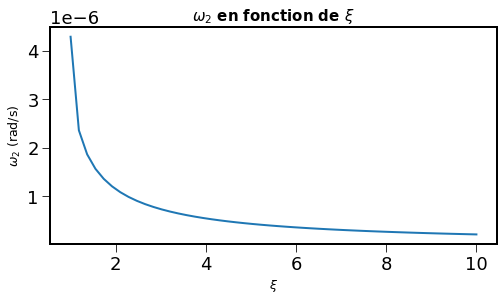

In [60]:
xis=np.linspace(1,10,50)
plt.plot(xis,func_omega2(xis))
plt.xlabel("$\\xi$")
plt.ylabel("$\omega_2$ (rad/s)")
plt.title("$\omega_2$ en fonction de $\\xi$")

- Il faut diminuer $\xi$ sans pouvoir jouer sur la valeur de $\alpha$ (rapport entre les capacités calorifiques)

- d'aileurs on ne mentionne pas la capacité calorifique de l'isolant, seulement sa réssitance thermique. 

$$
\omega_0 = \frac{1}{\sqrt{R_1R_2C_1C_2}} = \frac{1}{\sqrt{\alpha}\sqrt{R_1R_2} C} = \frac{2}{\sqrt{\alpha}\sqrt{1+2\beta} RC}
$$

et

$$
\xi = \frac{1}{2} \frac{R_1 + (1+\alpha)R_2}{\sqrt{\alpha}\sqrt{R_1R_2}} \approx \frac{1}{2} \frac{R_1 + \alpha R_2}{\sqrt{\alpha}\sqrt{R_1R_2}}
$$

#### Revetement intérieur
$$
R_1 = \frac{R_{mur}}{2} +  \beta R_{mur} = (1+2 \beta) \frac{R_{mur}}{2}\\
R_2 = \frac{R_{mur}}{2}
$$

$$
\xi = \frac{1}{2} \frac{1+ \alpha + 2 \beta}{\sqrt{\alpha}\sqrt{1+2\beta}}
$$



#### Revetement exterieur

$$
R_1 = \frac{R_{mur}}{2}  \\
R_2 = \frac{R_{mur}}{2} +  \beta R_{mur}
$$

$$
\xi = \frac{1}{2} \frac{1+ \alpha +  \alpha \beta}{\sqrt{\alpha}\sqrt{1+2\beta}}
$$


**Le $\xi$ le plus faible correspond au revêtement intérieur**

### Question 1.11.b $U_1$ et $U_2$ en régime statique

$$
R_1+R_2 = (1+ \beta) R_{mur}
$$



$$
\frac{U_1}{I_0} = (1+ \beta) R_{mur}
$$

$$
U_2 = U_1 \frac{R_2}{R_1+R_2} = \frac{(1+ \beta) }{2(1+\beta)}R_{mur}I_0
$$

### Question 1.11.c $H(j\omega)$ en régime dynamique

$$
\frac{U_1}{I_0} = \frac{1 + j \frac{R_1R_2}{R_1+R_2} \alpha C}{1 + j 2 \xi \frac{\omega}{\omega_0} - \left(\frac{\omega}{\omega_0}\right)^2}(R_1+R_2)
$$

$$
\frac{R_1R_2}{R_1+R_2} = \frac{1+2\beta}{1+\beta}\frac{R}{4}
$$

$$
R_1+R_2= (1+\beta) R
$$

$$
\omega_0 = \frac{2}{\sqrt{\alpha} \sqrt{1+2 \beta} RC}
$$

$$
\xi = \frac{1}{2} \frac{1+ \alpha + 2 \beta}{\sqrt{\alpha}\sqrt{1+2\beta}}
$$

#### calcul des pulsations $\omega_0,\omega_1,\omega_2, \omega_3$

- pulsation propre $\omega_0$:

$$
\omega_0 = \frac{2}{\sqrt{\alpha} \sqrt{1+2 \beta} RC}
$$

- le zéro $\omega_1$:

$$
\omega_1 = \frac{4}{\alpha RC} \frac{1+\beta}{1+2\beta}
$$

- un pôle avec une pulsation très faible $\omega_3$:
$$
\omega_3 = \omega_0(\xi - \sqrt{\xi^2-1})
$$

- un pôle avec une pulsation élevée $\omega_4$:
$$
\omega_4 = \omega_0(\xi + \sqrt{\xi^2-1})
$$

#### Application numérique

##### coefficient d'amortissement $\xi$

In [61]:
xi=0.5*(1+alpha+2*beta)/np.sqrt(alpha)/np.sqrt(1+2*beta)
xi # coefficient d'amortissement > 1 donc régime atténué

1.7050520170811156

- on a bien reussi à diminuer le coefficient d'amortissement donc on augmente $\omega_3$

##### pulsations  : $\omega_0,\omega_1,\omega_2, \omega_3$

In [62]:
# omega0
omega_0=2/np.sqrt(alpha)/RC/np.sqrt(1+2*beta)
omega_0 # rad/s

9.351718179520723e-07

In [63]:
# omega1
omega_1=4/alpha/RC*(1+beta)/(1+2*beta)
omega_1 # rad/s

3.1746031746031754e-07

In [64]:
# omega2
omega_2=omega_0*(xi - np.sqrt(xi**2-1))
omega_2 # rad/s

3.03030303030303e-07

In [65]:
# omega3
omega_3=omega_0*(xi + np.sqrt(xi**2-1))
omega_3 # rad/s

2.8860028860028868e-06

- Notez que $\omega_1 \simeq \omega_2$ : le zéro compense le premier pôle

### Question I.11.d

#### Diagramme de Bode

In [66]:
# numérateur de la fonction de la transformée de Laplace (bp +c) [b,c]
num = [ 1./omega_1 , 1. ]
num

[3149999.999999999, 1.0]

In [67]:
# dénominateur de la fonction de la transformée de Laplace (ap2 +bp +c) [a,b,c]
den = [1./omega_0**2, 2*xi/omega_0,  1.]
den

[1143449999999.9995, 3646499.9999999995, 1.0]

In [68]:
# appel à la librairie signal de scipy
s1 = signal.lti(num,den)
w, mag, phase = signal.bode(s1,w=X)

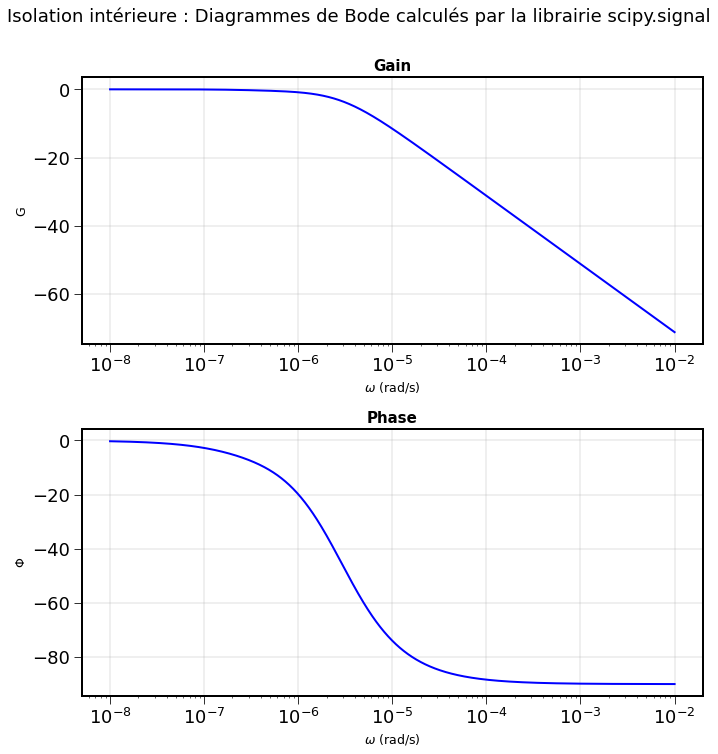

In [69]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.semilogx(w, mag,"b")    # Bode magnitude plot
plt.grid()
plt.xlabel("$\omega$ (rad/s)")
plt.ylabel("G")
plt.title("Gain")


plt.subplot(2,1,2)
plt.semilogx(w, phase,"b")  # Bode phase plot
plt.grid()
plt.xlabel("$\omega$ (rad/s)")
plt.ylabel("$\\Phi$")
plt.title("Phase")

plt.tight_layout()
plt.suptitle("Isolation intérieure : Diagrammes de Bode calculés par la librairie scipy.signal",y=1.05)
plt.show()


- **Je choisis sans hésitation la courbe $a$** qui garde le gain le plus élevé pour les pulsations les plus élevées.
Pour une puissance donnée $P$ la température intérieure est la plus élevée

$$
\frac{T_{int}}{P} = \frac{U_1}{I_0} = H(j\omega)
$$


# Quatrième partie : prise en compte des échanges de surfaces


## Partie I.1.2

In [70]:
k=10 # W/m2/K : coefficient de transfert thermique

### Question 1.2.a : Loi de Newton pour un échange convectif entre une surface et un fluide
$$
\vec{\Phi} = k S(T_s-T_f)\vec{n}
$$

- $k$ : coefficient de transfert thermique entre la surface et le fluide en W/m2/K

- $S$ : Surface de mur

- $\Phi = \frac{dQ}{dt}$ : flux de chaleur par unité de surface en W/m2

### Question 1.2.b

$$
\Phi = kS(T(L) - T_{ext})
$$

### Question 1.2.c

- en électrique:
$$
\Delta U = R I
$$
- en thermique
$$
\Delta T = R_{th} \Phi
$$

d'où la résistance thermique d'échange:
$$
R_{e} = \frac{1}{k S}
$$

In [71]:
Re= 1/k/S_p
Re  # K/W

0.0015384615384615385

In [72]:
Rth_mur # K/W

0.0015384615384615382

In [73]:
Rth_is # K/W

0.015384615384615385

- Le mur et la couche d'échange ont la même résistance thermique, qui est 10 fois inférieure à celle de l'isolant thermique

### Question I.12.d

- En l'absence d'isolation, on double la résistance thermique du mur 

$$
R_{th-tot}= R_{th-mur} + Re
$$

In [74]:
Rtot=Rth_mur + Re

In [75]:
Pe=DT/Rtot
Pe  # W : puissance pour maintenir la pièce à 20°

3250.0

### Question I.12.e

- Pour le sol : comme le sol est parfaitement isolé, sa résistance thermique est infinie.
L'échange thermique est bloqué. Rien ne change donc

-  Pour les fenêtres : Si la résistance thermique des fenêtres est faible, il n'en reste pas moins que la couche d'échange protège avec une resistance thermique :
$$ 
R_f = 2R_{ef} = \frac{2}{k S_{fenêtre}} = R_{e}\frac{S_{mur}}{S_{fenetre}} 
$$

- Les fenêtres présentant une plus faible surface que les murs, leur resistance thermique d'échange est plus élevée
que celle des murs

- Comme le flux de chaleur $\phi$ peut passer soit par les murs, soit par les fenêtres, on peut considérer que
la résistance des fenêtres est en parallèle avec la résistance des murs.
Donc la réssistance thermique totale est plus réduite.

### Question I.12.f

On a négligé le phénomène radiatif.
Les murs ont stocké de la chaleur qu'ils rayonnent la nuit (pas les fenêtres).